In [509]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import _autolag
from statsmodels.tsa.api import VAR
#from scipy.stats import pearsonr

DATA PREPARATION

In [510]:
data_df=pd.read_excel('Gas Data processed.xlsx',sheet_name="code")
df=data_df.loc[1:97,["year", "coal_gen", "gas_gen", "price_gas", "price_brent","open_interest_gas","ets"]] 
print(df)

#first ets value at line 38

              year  coal_gen  gas_gen   price_gas  price_brent  \
1   Quarter 2 1998   27.1609  26.3784   13.011204    18.739496   
2   Quarter 3 1998   25.9900  27.5545   19.397759    20.560224   
3   Quarter 4 1998   30.2032  32.6438   16.545961    14.665738   
4   Quarter 1 1999   29.1229  35.9817   12.819444    21.166667   
5   Quarter 2 1999   21.5152  32.0022   13.645117    24.085282   
..             ...       ...      ...         ...          ...   
91  Quarter 4 2020    1.2246  31.1309   51.601098    47.392498   
92  Quarter 1 2021    2.1945  32.3960   42.739726    58.027397   
93  Quarter 2 2021    0.6989  30.7469   77.430117    67.745717   
94  Quarter 3 2021    1.3825  28.9004  224.267857    70.107143   
95  Quarter 4 2021    1.7048  29.7824  149.553024    68.168273   

    open_interest_gas        ets  
1                 875        NaN  
2                3360        NaN  
3                6490        NaN  
4                2425        NaN  
5                2455        NaN

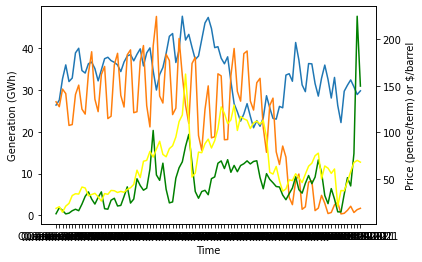

In [511]:
plt.plot(df.year, df.gas_gen)
plt.plot(df.year, df.coal_gen)
plt.xlabel("Time")
plt.ylabel("Generation (GWh)")
#plt.grid()
plt2=plt.twinx()
plt2.plot(df.year, df.price_gas, color="green")
plt2.plot(df.year, df.price_brent, color="yellow")
plt2.set_ylabel("Price (pence/term) or $/barrel", color="black")
#plt.ylabel
plt.show()

In [512]:
#Vector:
dcoal=df.coal_gen
dgas=df.gas_gen
dprice_gas=df.price_gas
dprice_brent=df.price_brent
dOI=df.open_interest_gas
dETS=df.ets

DataSeries=[dcoal,dgas,dprice_gas, dprice_brent,dOI]
#DataSeries=[dcoal,dgas,dprice_gas]


In [513]:
######### INITIAL DATA TESTS #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary

from statsmodels.tsa.stattools import adfuller, kpss
######## NORMALITY TEST V2 ########

def normality_test_matrix(data, variables, test):    
    """Check normality test to comply with general model assumptions.
    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    test      : type of test to perform
    """

    col=['test statistic ','p-value ', 'lags used ']
    df = pd.DataFrame(np.zeros((len(variables), 3)), columns=col, index=variables)
    for r in df.index:
        if test == "Dickey-Fuller":
            dftestdickey = adfuller(data[r].values, autolag='AIC')
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestdickey[c]           
        elif test == "KPSS":
            dftestkpss = kpss(data[r].values, regression='c', nlags="auto")
            for c in range(0,len(col)):
                df.loc[r, col[c]] = dftestkpss[c]

    print("Results for "+test+" test")
    df.columns = [var + test for var in col]

    #df.index = [var for var in variables]s
    return df


### styles ###

def highlight_cells_DF(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e < 0.05 else highlight_false for e in series]  

def highlight_cells_KPSS(series):
    highlight_true = 'background-color: green;'
    highlight_false = 'background-color: red;'
    default = ''
    return [highlight_true if e > 0.05 else highlight_false for e in series]  


dfdifull = normality_test_matrix(df_test, variables = df_test.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)

Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
coal_gen,-0.192597,0.939398,11.000000
gas_gen,-2.007914,0.283114,2.000000
price_gas,-3.453892,0.009253,4.000000
price_brent,-2.228530,0.196054,0.000000
open_interest_gas,-1.716164,0.422804,6.000000
ets,2.869431,1.000000,6.000000


In [514]:
dfkpss = normality_test_matrix(df_test, variables = df_test.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
coal_gen,1.073109,0.010000,4.000000
gas_gen,0.431070,0.063763,4.000000
price_gas,0.103736,0.100000,3.000000
price_brent,0.761952,0.010000,4.000000
open_interest_gas,1.111221,0.010000,4.000000
ets,0.999275,0.010000,4.000000


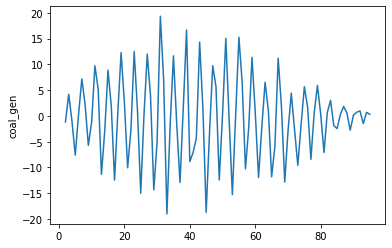

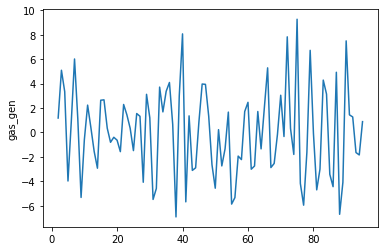

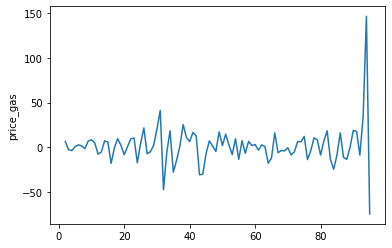

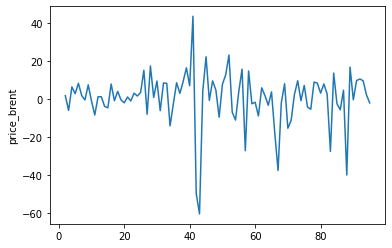

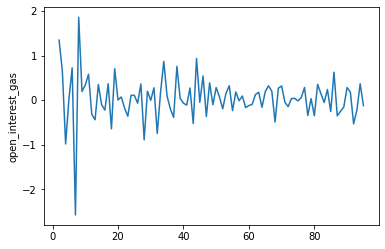

In [515]:
######### DATA CORRECTION #########
#ideally, for each set, apply specific changes
# detrending for linear processes
# differences for random walks 
# other ? non linear processes

#### differentiate 1
DataSeriesCorr=[]
for df in DataSeries:
    if df.name == "open_interest_gas":
        df_log = pd.Series(np.log(df))
        df = df_log
    df_diff = df.diff().dropna()
    plt.plot(df_diff)
    plt.ylabel(df.name)
    plt.show()
    DataSeriesCorr.append(df_diff)

DataSeries = DataSeriesCorr

df_corr = pd.concat(DataSeriesCorr,axis=1)

In [516]:
######### STATIONARITY DATA TEST #########

# stationarity describe an evolution following the same pattern overtime. Hence the relationship between variable are static
# stationarity test
# seasonality is not an issue as it can be predictable
# non linear trend can be corrected via applying a log
# take the difference to make the data stationary


dfdifull = normality_test_matrix(df_corr, variables = df_corr.columns, test="Dickey-Fuller")
dfdifull.style.apply(highlight_cells_DF, subset=['p-value Dickey-Fuller'], axis=0)


Results for Dickey-Fuller test


,test statistic Dickey-Fuller,p-value Dickey-Fuller,lags used Dickey-Fuller
coal_gen,-4.289703,0.000463,5.000000
gas_gen,-10.445775,0.000000,1.000000
price_gas,-5.113911,0.000013,6.000000
price_brent,-8.215813,0.000000,1.000000
open_interest_gas,-7.733532,0.000000,2.000000


In [517]:
dfkpss = normality_test_matrix(df_corr, variables = df_corr.columns, test="KPSS")
dfkpss.style.apply(highlight_cells_KPSS, subset=['p-value KPSS'], axis=0)

Results for KPSS test


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range

,test statistic KPSS,p-value KPSS,lags used KPSS
coal_gen,0.161920,0.100000,14.000000
gas_gen,0.205228,0.100000,23.000000
price_gas,0.164709,0.100000,13.000000
price_brent,0.129062,0.100000,6.000000
open_interest_gas,0.206441,0.100000,22.000000


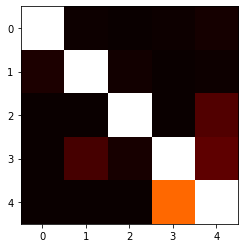

,coal_gen_x,gas_gen_x,price_gas_x,price_brent_x,open_interest_gas_x
coal_gen_y,1.0000,0.0046,0.0001,0.0072,0.0175
gas_gen_y,0.0291,1.0000,0.0125,0.0003,0.0078
price_gas_y,0.0005,0.0018,1.0000,0.0008,0.1090
price_brent_y,0.0033,0.0900,0.0218,1.0000,0.1257
open_interest_gas_y,0.0011,0.0026,0.0001,0.5204,1.0000


In [518]:
#### CORRECTED GRANGER CAUSALITY ####

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    plt.imshow(df, cmap='hot', interpolation='nearest')
    plt.show()
    return df


##### actual test
grangers_causation_matrix(df_corr, variables = df_corr.columns)        


In [519]:
def plot_gen(series):
    plt.figure(figsize=(12,6))
    plt.plot(series, color='red')
    plt.grid()
    plt.ylabel('Generation output (GWh)', fontsize=16)

def plot_price(series):
    plt.figure(figsize=(12,6))
    plt.plot(series, color='green')
    plt.grid()
    plt.ylabel('Price p/term', fontsize=16)

def plot_basic(series, name):
    plt.figure(figsize=(9,4))
    plt.plot(series)
    plt.ylabel(name, fontsize=10)
    plt.grid()


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


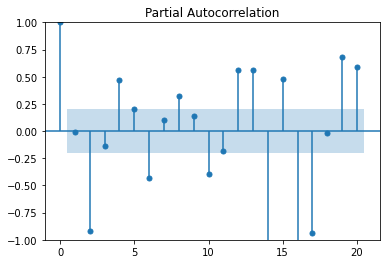

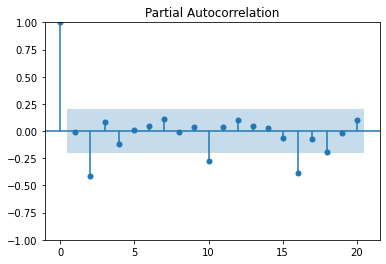

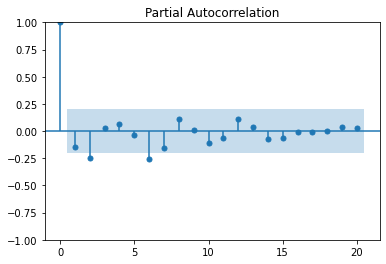

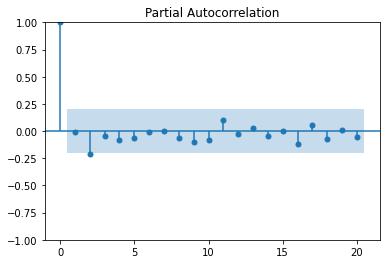

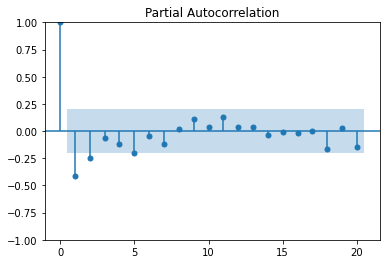

In [520]:
######### LAG LENGTH CRITERIA ######### either multiple of frequency or Schwarz, akaike, hannan-quinn, bayesian 

for df in DataSeries:
    plot_pacf(df)
    plt.show()



# for df in DataSeries:
#     lag_selection = _autolag(mod=VAR,endog=df, exog=df, startlag=1, maxlag=30, method="aic")
#     lag_selection.results()
#     #plt.show()




In [521]:
##### MODEL FITTING #####

model = VAR(df_corr)
x = model.select_order(maxlags=7)
x.summary()
#model_fit = model.fit(maxlags=10, ic="aic") #aic, or bic
#model_fit.summary()


#model_fit.plot()


/Users/lucruffie/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,16.18,16.32,1.061e+07,16.23
1,15.95,16.80,8.446e+06,16.29
2,14.11*,15.67*,1.352e+06*,14.74*
3,14.23,16.50,1.551e+06,15.15
4,14.15,17.13,1.468e+06,15.35
5,14.30,17.99,1.789e+06,15.79
6,14.22,18.62,1.770e+06,15.99
7,14.38,19.48,2.291e+06,16.43


In [522]:
##### MODEL FITTING BASED ON LAG CRITERIA RESULTS ######

lag_order = 2
model_fit = model.fit(lag_order)
model_fit.summary()

#model_fit.plot()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Jun, 2022
Time:                     10:50:59
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    16.0359
Nobs:                     92.0000    HQIC:                   15.1368
Log likelihood:          -1266.01    FPE:                2.05141e+06
AIC:                      14.5283    Det(Omega_mle):     1.16629e+06
--------------------------------------------------------------------
Results for equation coal_gen
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                       -0.573066         0.374750           -1.529           0.126
L1.coal_gen                 -0.005937         0.059852           -0.099           0.921
L1.gas_gen                  -

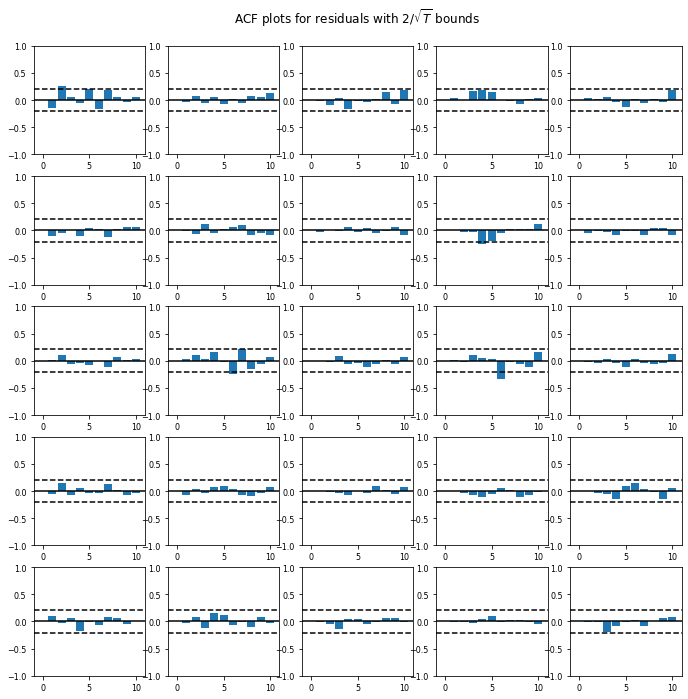

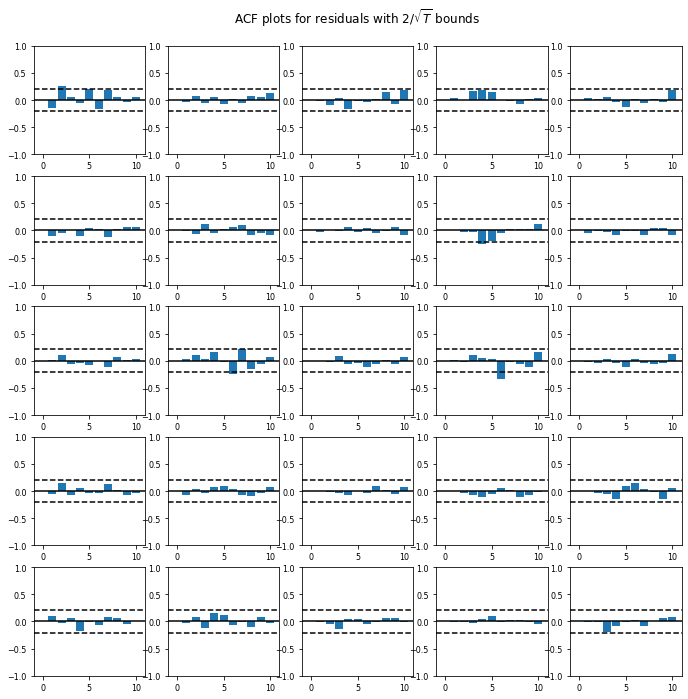

In [523]:
######### STABILITY RESIDUALS AUTOCORRELATION #########
model_fit.plot_acorr()

#if residuals out of range -> unstable model 

In [533]:
######### GRANGER CAUSALITY TEST #########
#for gas price
GrangerCausality = model_fit.test_causality('price_gas', ['price_brent'], kind='f')
print(GrangerCausality.summary())

#granger causality test : HO not rejected => there is some causality between the variables

#importance of the order: if p value higher, does it mean that one variable is generating the other ?

Granger causality F-test. H_0: price_brent does not Granger-cause price_gas. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         5.516          3.018   0.004 (2, 405)
----------------------------------------------


FEVD for coal_gen
      coal_gen   gas_gen  price_gas  price_brent  open_interest_gas
0     1.000000  0.000000   0.000000     0.000000           0.000000
1     0.955646  0.005530   0.010650     0.026831           0.001343
2     0.937961  0.013042   0.006960     0.039101           0.002936
3     0.915230  0.017461   0.013070     0.049215           0.005025
4     0.902730  0.028299   0.010769     0.053654           0.004548
5     0.891411  0.031745   0.013840     0.057480           0.005524
6     0.884390  0.040422   0.012013     0.058232           0.004944
7     0.877202  0.043259   0.014085     0.060046           0.005409
8     0.873352  0.049360   0.012615     0.059710           0.004963
9     0.867964  0.051796   0.014242     0.060765           0.005233
10    0.865801  0.055930   0.013075     0.060290           0.004905
11    0.861485  0.058069   0.014395     0.060955           0.005096
12    0.860248  0.060837   0.013470     0.060597           0.004847
13    0.856713  0.062737   0.0

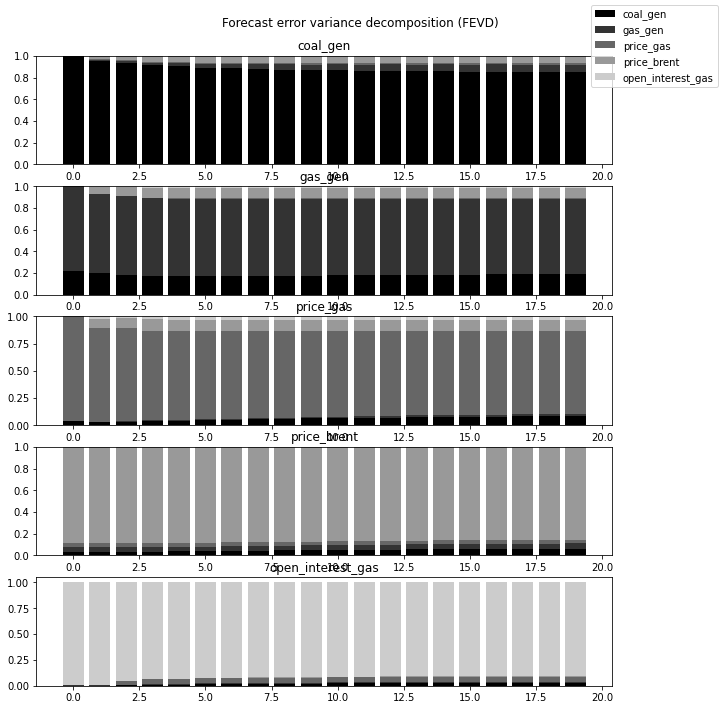

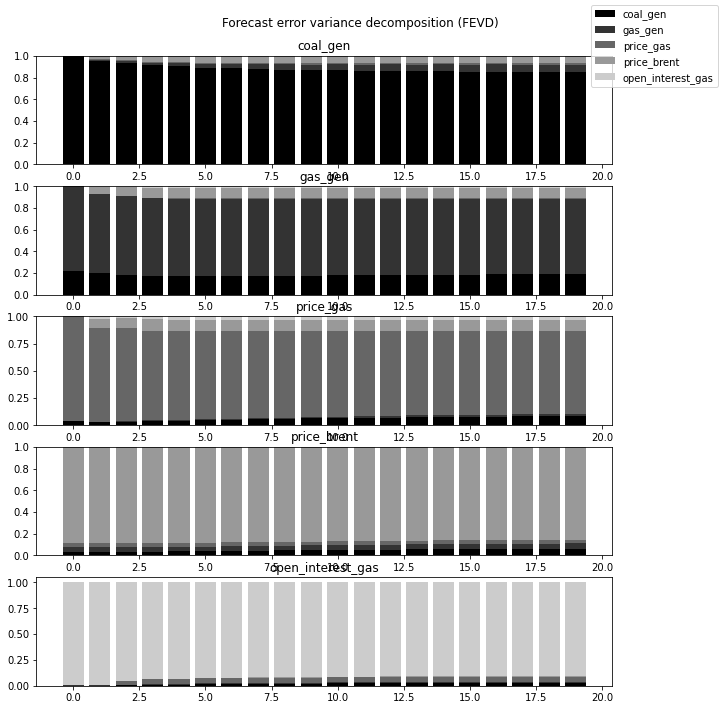

In [527]:
######### FORECAST VARIANCE ERROR DECOMPOSITION: #########

#only for 20 periods
n=20
fevd = model_fit.fevd(n)
fevd.summary()


#affichage pour n périodes
model_fit.fevd(n).plot()

IMPULSE RESPONSE ANALYSIS:

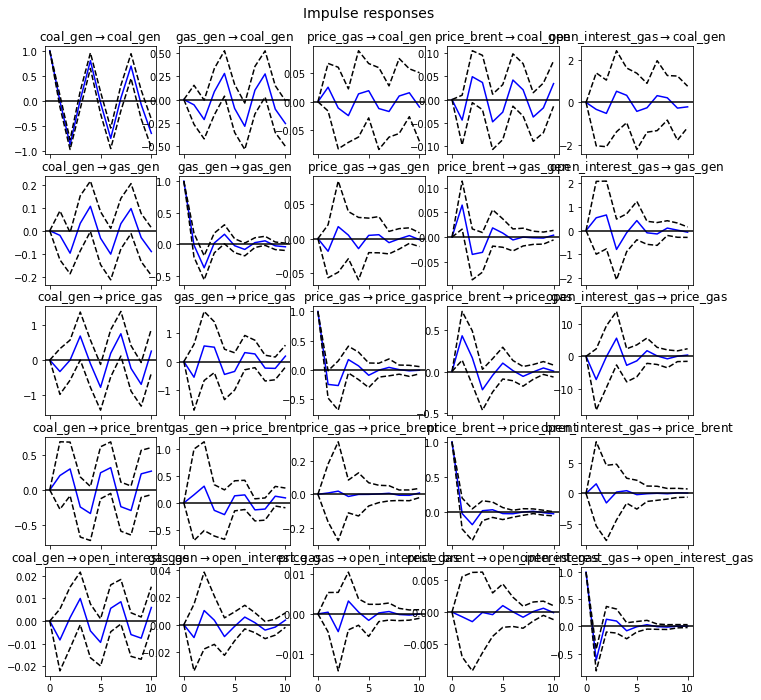

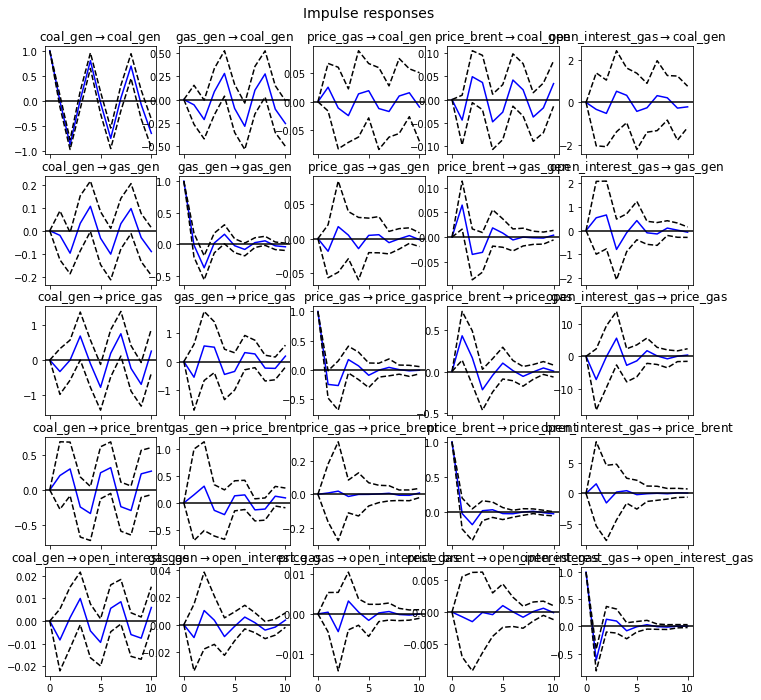

In [ ]:
irf = model_fit.irf(10)
irf.plot()

OTHER MODELS

In [534]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_corr, order=(0, 2, 2)) 
results_ARIMA = model.fit()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.
